# Задача классификации

Отличительной особенностью задачи классификации от задачи регрессии является область значений целевой переменной. Если в задаче регрессии целевая переменная $y$ принимала вещественные значения, то в задаче классификации $y$ принадлежит конечному дискретному множеству.

В случае, когда моножество значений состоят всего из 2-х элементов говорят о задаче бинарной классификации.

## Пример. Задача опеределения поддельных банкнот

С описание этого набора данных можно ознакомиться по [ссылке](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#).

В нем описывается задача классификации банкнот на настоящие (класс 0) и фальшивые (класс 1). Каждая банкнота описывается 4-мя числовыми признаками, которые получены путем применения различных вейвлетных преобразований к фотографиям банкноты.

Имеются следующие признаки:
* variance (разброс)
* skewness (ассиметрия)
* curtosis (эксцесс)
* entropy (энтропия)

Целевая переменная задача в столбце *class* и принимает значения 0 или 1.

## Разведывательный анализ данных

Загрузим описанный выше набор данных и изучим его характеристики

In [1]:
import numpy as np
# import scipy.linalg as sla
import matplotlib.pyplot as plt

# from sklearn import datasets
# from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

In [2]:
import pandas as pd

dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt'

ds = pd.read_csv(dataset_url,
                 names = [
                     'variance',
                     'skewness',
                     'curtosis',
                     'entropy',
                     'class',
                 ],
                )
ds.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## Визуализация классов
Для простоты будем рассматривать только 2 признака: разброс (variance) и ассиметрию (skewness). 

Потсроим график по этим двум признакам и раскрасим точки, принадлежащие разным классам с помощью различных цветов.

На графике хорошо видно, что имеется два распределения, которые пересекаются между собой. 

Для решения задачи классификации нам необходимо построить решающее правило. В данном случае его можно представить в виде прямой на плоскости, которая "наилучшим" способом разделит распределения. После чего все точки по одной стороне от прямой можно считать принадлежащими классу 0, а по другую сторону - классу 1.

При этом возникают следующие вопросы:

* как вычислить коэффициенты этой прямой?
* что означает "наилучшим" способом разделит?

Попробуем нарисовать несколько таких прямых.

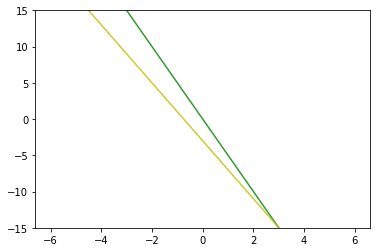

In [3]:
import numpy as np

lines = [([0, -5], 'g'),
         ([-3, -4], 'y')]

for line in lines:
    x = np.linspace(-6, 6, 100)
    y = line[0][0] + x*line[0][1]
    plt.plot(x, y, color=line[1], alpha=0.8)
plt.ylim((-15, 15));

Из графика видно, что какую-бы прямую мы не выбрали всегда будут точки из обучающей выборки, на которых классификатор будет давать неверный результат. Вычислить для преведенных выше двух прямых такую характеристику как точность (accuracy), которая предсатвляет собой нормированное на единицу число правильных решений классификатора.

In [4]:
from sklearn.metrics import accuracy_score

acc = []
for line in lines:
    pred = ds['skewness'] - line[0][1]*ds['variance'] - line[0][0] < 0
    acc.append(accuracy_score(ds['class'], pred))

print(f"Точность для зеленой прямой: {acc[0]:.3}")
print(f"Точность для желтой прямой: {acc[1]:.3}")

Точность для зеленой прямой: 0.873
Точность для желтой прямой: 0.848


## Логистическая регрессия

Сравнивая результаты мы видим, что точность для зеленой прямой выше, а следовательсно, с точки зрения данного критерия, это решаюшее правило "лучше" желтой прямой.

Подобные рассуждения приводят нас к следующей формальной постановке задачи: следует поставить задачу оптимизации, где в качестве варьируемых параметров будут параметры разделяющей прямой, а в качестве минимизируемой функции - функция обратная к точности.

Попробуем записать это в формальной нотации и сразу для $n$-мерного случая.

Пусть $\theta = (\theta_0, \theta_1, \dots, \theta_n)$ - коэффициенты канонического представления гиперплоскости (для двумерного случая - это будет прямая).

$x = (1, x_1, x_2, \dots, x_n)$ - расширенный вектор признаков (с дополнительной единицей).


Будем называть один из классов - положительными примерами, а другой - отрицательными. Пусть целевая переменая $y$ принимает значение $1$ для примеров из положительного класса, и значение $0$ для примеров из отрицательного класса.


Сформулируем гипотезу $h_\theta(x)$ так, чтобы область ее значений лежала в отрезке $[0, 1]$, а область значений совпадала с $\mathbb{R}$. Из функций, которые обладаюст подобными свойствами выделим и рассмотрим логистическую кривую
$$
\sigma(z) = \frac{1}{1 + e^{-z}}.
$$

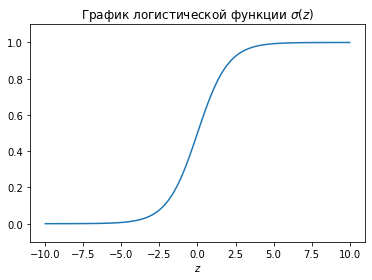

In [5]:
z = np.linspace(-10, 10, 100)
sigma = 1/(1+np.exp(-z))
plt.plot(z, sigma)
plt.ylim(-0.1, 1.1)
plt.xlabel('$z$')
plt.title('График логистической функции $\sigma(z)$');

Запишем гипотезу $h_\theta(x)$ с помощью логистической функции $\sigma(z)$ в виде
$$
h_\theta(x) = \sigma(\theta^Tx).
$$

Значение гипотезы $h_\theta(x)$ будем трактовать как вероятность того, что объект, описываемый вектором признаков $x$, принадлежит к положительному классу $h_\theta(x) = P(y=1 |~x; \theta)$. Соответственно $1 - h_\theta(x) = P(y = 0 |~x; \theta)$ - вероятность тогоа, что объект принадлежит к отрицательному классу.

## Пример. смесь нормальных распределений

В качестве иллюстрирующего примера рассмотрим задачу классификации, в которой примеры обучающей выборки имеют одномерный признак и соответсвуют двум нормальным распределениями

Text(0.5, 1.0, 'Разделение двух распределений')

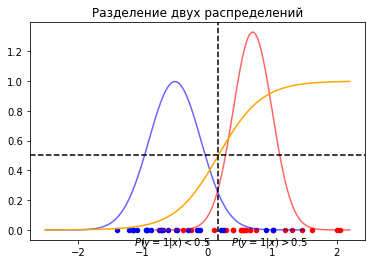

In [6]:
import math
from scipy.stats import norm

np.random.seed(10)

mean_0 = 0.7
std_0 = 0.3

mean_1 = -0.5
std_1 = 0.4

nsamples_0 = 100
nsamples_1 = 100

samples_0 = mean_0 + math.sqrt(std_0)*np.random.randn(nsamples_0)
samples_1 = mean_1 + math.sqrt(std_1)*np.random.randn(nsamples_1)

x_0 = np.linspace(mean_0 - 5*std_0, mean_0 + 5*std_0, 100)
x_1 = np.linspace(mean_1 - 5*std_1, mean_1 + 5*std_1, 100)


from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(np.hstack((samples_0, samples_1)).reshape(-1, 1),
                               np.hstack(([1]*nsamples_0, [0]*nsamples_1)))
theta_0 = clf.intercept_[0]
theta_1 = clf.coef_[0][0]

x = np.linspace(mean_1 - 5*std_1, mean_0 + 5*std_0)
sigma = 1/(1 + np.exp(-(theta_0 + theta_1*x)))

draw_samples = 25

plt.scatter(x = np.random.choice(samples_0, draw_samples), y = [0]*draw_samples, color='red', s=20)
plt.plot(x_0, norm.pdf(x_0, mean_0, std_0), color='red', alpha=0.6)

plt.scatter(x = np.random.choice(samples_1, draw_samples), y = [0]*draw_samples, color='blue', s=20)
plt.plot(x_1, norm.pdf(x_1, mean_1, std_1), color='blue', alpha=0.6)

plt.plot(x, sigma, color='orange')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(-theta_0/theta_1, color='black', linestyle='--')
plt.text(-theta_0/theta_1 + 0.2, -0.1, '$P(y=1|x) > 0.5$')
plt.text(-theta_0/theta_1 - 1.3, -0.1, '$P(y=1|x) < 0.5$')
plt.title('Разделение двух распределений')

## Функция потерь

Использование такой же функци потерь, что и для метода линейной регресси, т.е. среднеквадратичная ошибка осложнено тем фактом, что при использовании неинейной гипотезы $h_\theta(x)$ нет гарантии, что функция потерь вида
$$
L(\theta) = \frac{1}{2n}\sum\limits_{i=1}^{n}\left(h_\theta(x^{(i)}) - y^{(i)}\right)^2
$$
будет иметь выпуклый вид.

Проверим это утверждение на примере классификации по росту и весу на мужчин и женщин. Упростим для наглядности задачу и будем рассматривать только рост. В качестве гипотезы рассмотрим однопараметрическую функцию $h_\theta(x) = \theta x$ без свободнго параметра. Построим график $L(\theta)$

In [7]:
def mse(theta, x, y):
    n = len(y)
    def sigma(z):
        return 1/(1 + np.exp(-z))
    return 1/(2*n)*np.sum((sigma(theta*x) - y)**2)

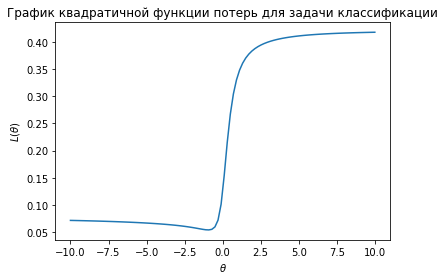

In [8]:
x = ds['variance']
y = ds['class']

theta = np.linspace(-10, 10, 100)
L = [mse(th, x, y) for th in theta]
plt.plot(theta, L)
plt.xlabel('$\\theta$')
plt.ylabel('$L(\\theta)$')
plt.title('График квадратичной функции потерь для задачи классификации');

## Логистическая  функция потерь

Рассмотрим в качестве функции потерь для метода логистической регресии выражение вида
$$
L(\theta) = - \frac{1}{n}\sum\limits_{i=1}^n\begin{cases}
\log (1-h_\theta(x^{(i)})),&& y^{(i)} = 0 \\
\log h_\theta(x^{(i)}),&& y^{(i)} = 1.
\end{cases}
$$

Для понимания вида $L(\theta)$ рассмотрим как ведут себя слагаемые для $y = 0$ и $y = 1$ по отдельности.

Text(0.5, 1.0, '$y = 1, -\\log h_\\theta(x^{(i)})$')

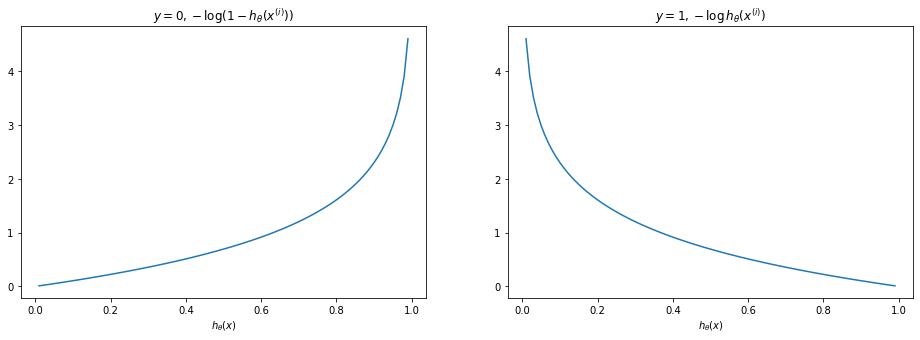

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
h = np.linspace(0.01, 0.99, 100)
ax[0].plot(h, -np.log(1 - h))
ax[0].set_xlabel('$h_{\\theta}(x)$')
ax[0].set_title('$y = 0, -\\log (1-h_\\theta(x^{(i)}))$')
ax[1].plot(h, -np.log(h))
ax[1].set_xlabel('$h_{\\theta}(x)$')
ax[1].set_title('$y = 1, -\\log h_\\theta(x^{(i)})$')

На левом графике хорошо видно, что в случае, когда истинный класс ($y = 0$), то данная функция потерь награждает нас, когда гипотеза $h_\theta(x) \rightarrow 0$ и штрафует, когда $h_\theta(x) \rightarrow 1$. В случае другого класса $(y = 1$) все с точностью до наоборот. Функция потерь награждает нас при $h_\theta(x) \rightarrow 1$ и штрафует при $h_\theta(x) \rightarrow 0$.

Посмотрим как выглядит сумма подобных штрафов для всей обучающей выборки в зависимости от параметра $\theta$.

In [10]:
def logloss(theta, x, y):
    n = len(y)
    def sigma(z):
        return 1/(1 + np.exp(-z))
    return -1/n*np.sum(y*np.log(sigma(theta*x)) + (1-y)*np.log(1 - sigma(theta*x)))

/home/leon/Projects/Programming/Study/Python/ML_Study/Linear Models/venv/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


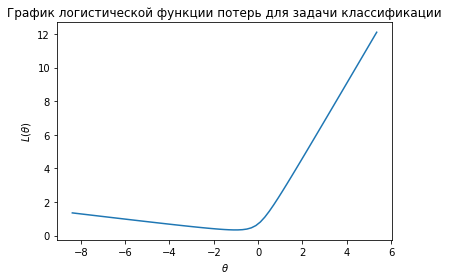

In [11]:
x = ds['variance']
y = ds['class']

theta = np.linspace(-10, 10, 100)
L = [logloss(th, x, y) for th in theta]
plt.plot(theta, L)
plt.xlabel('$\\theta$')
plt.ylabel('$L(\\theta)$')
plt.title('График логистической функции потерь для задачи классификации');

Из графика хорошо видно, что построенная функция потерь имеет выпуклый вид, а следовательно для нахождения ее минимума хорошо подойдет метод градиетного спуска.

Для этого найдем перепишем функцию потерь в эквивалентном виде
$$
L(\theta) = -\frac{1}{n}\sum\limits_{i=1}^n\left[y^{(i)}\log h_\theta(x^{(i)}) + (1 - y^{(i)})\log\left(1 - h_\theta(x^{(i)})\right)\right] = -\frac{1}{n}\sum\limits_{i=1}^n\left[y^{(i)}\log \sigma(\theta^Tx^{(i)}) + (1 - y^{(i)})\log\left(1 - \sigma(\theta^Tx^{(i)})\right)\right].
$$

И найдем ее производную 
$$
\frac{\partial L}{\partial \theta_j} = -\frac{1}{n}\sum\limits_{i=1}^n \left[ \frac{ y^{(i)} \sigma'(\theta^Tx^{(i)})}{\sigma(\theta^T x^{(i)})}  - \frac{(1 - y^{(i)}) \sigma'(\theta^Tx^{(i)})}{1 - \sigma(\theta^T x^{(i)})}\right] x_j^{(i)}.
$$
Учитывая, что
$$
\sigma'(z) = \left(\frac{1}{1 + e^{-z}}\right)' = \frac{e^{-z}}{(1 + e^{-z})^2} = \frac{1 - 1 + e^{-z}}{(1 + e^{-z})^2} = \frac{1}{1 + e^{-z}} \left(1 - \frac{1}{1 + e^{-z}}\right) = \sigma(z)(1 - \sigma(z)),
$$
получаем
$$
\frac{\partial L}{\partial \theta_j} = -\frac{1}{n}\sum\limits_{i=1}^n \left[y^{(i)}(1 - \sigma(\theta^Tx^{(i)})) - 
(1 - y^{(i)})\sigma(\theta^Tx^{(i)})\right]x_j^{(i)} = -\frac{1}{n}\sum\limits_{i=1}^n \left[y^{(i)} - 
\sigma(\theta^Tx^{(i)}) \right]x_j^{(i)}.\quad j = \overline{1,m}.
$$

Или в матричном виде

$$
grad ~ L(\theta) = \frac{1}{n}X^T(\sigma(X\theta^T) - y).
$$

Здесь мы считаем, что $\sigma$ применяется к каждому элементу вектора $X\theta^T$.

## Метод градиентного спуска
 
Найден параметры логистической регресси для нашей тестовой задачи с помощью метода градиентного спуска

In [12]:
def sigma(z):
    return 1/(1+np.exp(-z))

def grad(y, X, theta):
    n = y.shape[0]
    return 1/n * X.transpose() @ (sigma(X @ theta) - y)

def L(y, X, theta):
    n = y.shape[0]
    return -1/(n)*np.sum(y*np.log(sigma(X @ theta)) + (1 - y)*np.log(1 - sigma(X @ theta)))

def fit(y, X, theta_0, alpha=0.001, nsteps = 100):
    theta = np.copy(theta_0)
    loss = [L(y, X, theta)]
    for i in range(nsteps):
        theta -= alpha*grad(y, X, theta)
        loss.append(L(y, X, theta))
    return loss, theta

## Предобработка данных

Для лучшей сходимости метода проведем нормализацию признаков.

In [13]:
X = ds[['variance', 'skewness']]
y = ds['class']

X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)

norm_X = (X - X_mean)/X_std

In [32]:
from Logistic_Regression import LogisticRegression

n = len(X)
X = np.hstack((np.ones((n, 1)), norm_X))
m = 2
theta_0 = np.zeros(m + 1)
loss_history, theta_star = fit(y, X, theta_0, alpha=1e-2, nsteps=5000)

lr = LogisticRegression()
lr.fit(X[:, 1:3], y[:, np.newaxis], 2)
lr.train(lr=0.01, iter=100, L1=0.1, L2=0.1)



/home/leon/Projects/Programming/Study/Python/ML_Study/Linear Models/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 100/100 [00:04<00:00, 22.17it/s]


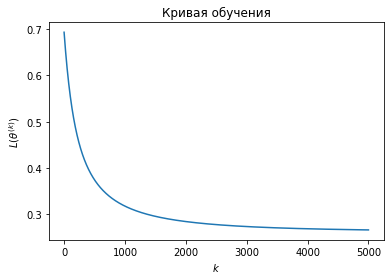

In [34]:
plt.plot(loss_history)
plt.xlabel('$k$')
plt.ylabel('$L(\\theta^{(k)})$')
plt.title('Кривая обучения');

Построим получившуюся разделяющую гиперплоскость с параметрами $\theta^*$

In [35]:
theta_star

array([-0.37417584, -2.64253207, -1.34393351])

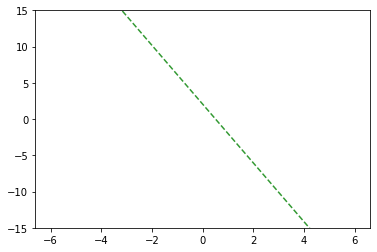

In [36]:


x_tmp = np.linspace(-6, 6, 100)
y_tmp = - (theta_star[0] + (x_tmp - X_mean[0])/X_std[0]*theta_star[1])/theta_star[2]

plt.plot(x_tmp, X_std[1]*y_tmp + X_mean[1] , color="green", alpha=0.8, linestyle='--')
plt.ylim((-15, 15));

Вычислим число правильных ответов для получившегося классификатора

In [ ]:
y_pred = X @ theta_star > 0
logreg_score = accuracy_score(y, y_pred)
print(f'Logistic Regression accuracy: {logreg_score:.3f}')

## Нелинейная разделяющая поверхность

В качестве примера задачи классификации, который требует построения нелинейных разделяющих поверхностей, рассмотрим набора данных с результатами тестов микропроцессоров.

In [ ]:
microchip = pd.read_csv(
    '../datasets/microchip_test.csv',
    names=['Test1', 'Test2', 'Passed'],
)

In [ ]:
sns.scatterplot(x='Test1', y='Test2', hue='Passed', data=microchip, s=100);

На рисунке хорошо видно, что разделяющая граница должна иметь нелинейный вид. Попробуем добавить квадратичные признаки в наш набор данных.
$$
x' = \begin{pmatrix}1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2\end{pmatrix}.
$$

In [ ]:
n = len(microchip)
m = 2
tmpX = np.ones((n, m))
X = np.zeros((n, 2*(m+1)))
tmpX[:] = microchip[['Test1', 'Test2']]
for i in range(n):
    X[i, :] = np.array([1, tmpX[i, 0], tmpX[i, 1], tmpX[i, 0]**2, tmpX[i, 0]*tmpX[i, 1], tmpX[i, 1]**2])
y = microchip['Passed'].values

In [ ]:
theta_0 = np.zeros(2*(m+1))
loss_history, theta_star = fit(y, X, theta_0, alpha=1e-1, nsteps=20000)

In [ ]:
plt.plot(loss_history)
plt.xlabel('$k$')
plt.ylabel('$L(\\theta^{(k)})$')
plt.title('Кривая обучения');

## Разделяющая кривая

In [ ]:
import warnings
warnings.filterwarnings('ignore')
npoints = 500
x1 = np.linspace(-1.0, 1.25, npoints)
x2 = np.linspace(-1.0, 1.25, npoints)
xx1, xx2 = np.meshgrid(x1, x2)

def decision_func(x, theta):
    return theta[0] + theta[1]*x[0] + theta[2]*x[1] + theta[3]*x[0]**2 + theta[4]*x[0]*x[1] + theta[5]*x[1]**2

points = np.c_[xx1.ravel(), xx2.ravel()]
Z = np.array([1 if decision_func(x, theta_star) > 0 else 0 for x in points])
Z = Z.reshape(xx1.shape)

sns.scatterplot(x='Test1', y='Test2', hue='Passed', data=microchip, s=100);
plt.contour(xx1, xx2, Z, levels=[0], colors='green', alpha=0.6, linestyles='--');

## Источники

1. *Christopher M. Bishop.* Pattern Recognition and Machine Learning. Logistic regression. pp. 205
2. *Andrew Ng.* Logistic Regression - [coursera](https://www.coursera.org/learn/machine-learning/home/week/3)
3. *К. В. Воронцов* Линейные методы классификации: метод стохастического градиента - [video](https://yandexdataschool.ru/edu-process/courses/machine-learning#item-4), [slides](http://www.machinelearning.ru/wiki/index.php?title=Машинное_обучение_%28курс_лекций%2C_К.В.Воронцов%29#.D0.93.D1.80.D0.B0.D0.B4.D0.B8.D0.B5.D0.BD.D1.82.D0.BD.D1.8B.D0.B5_.D0.BC.D0.B5.D1.82.D0.BE.D0.B4.D1.8B_.D0.BE.D0.B1.D1.83.D1.87.D0.B5.D0.BD.D0.B8.D1.8F)
3. *Ю. Кашницкий.* Открытый курс машинного обучения. Тема 4. Линейные модели классификации и регрессии - [habr](https://habrahabr.ru/company/ods/blog/323890/)
